In [1]:
from utils import sars2_genome_info, get_parent
from utils_convergence import count_independent_occurrences, convergent_evo_dataframe, mean_rate_on_tree 
from utils_convergence import calc_mean_rate, rates_randomized_mut
from utils_randomization import get_branch_lengths, randomize_specific_mutations_multinomial
from utils_plotting import get_color_palette, convert_linege_names
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from collections import Counter
from scipy import stats
from os import path
import os
import requests
import random
import json

/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


## Figure 4: A 3-amino acid deletion in Nsp6 displays convergent evolution and occurs in successful clades

##### Mutations that appear many times over course of natural evolution of SARS-CoV-2 (convergently-evolved mutations) and are inherited by a descending clade (don't just die out) could be beneficial. They are likely neutral at worst. To find mutations associated with clade success, look for convergently-evolved mutations with high logistic growth rates after each independent occurrence

#### This notebook completes the analyses for Figures 4 A and B and Figure 4 Supplements 1 and 2. 

Import the tree and convert to Bio Phylo format. This is a time-resolved phylogeny built from 9544 SARS-CoV-2 genomes sampled between December 2019 and May 15, 2021. The tree can be viewed at https://nextstrain.org/groups/blab/ncov/adaptive-evolution/2021-05-15

In [2]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Find all mutations that occurred on internal branches of the phylogeny (with at least 15 descending tips). Count how many times each of these mutations arose independently

In [3]:
all_mutations_unique, independent_occurrences_all_mutations = count_independent_occurrences(tree)

Plot a histogram of the number of independent times a mutation appears in the natural history of the virus. Just for interest, not to be included in the figure

In [4]:
def histogram_of_occurrences(filename=None):
    

    df = pd.DataFrame([{"mutation": mutation, "independent_occurrences": value} 
                       for mutation, value in independent_occurrences_all_mutations.items()])
    
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.histplot(x = 'independent_occurrences', data = df, ax=ax, discrete=True, 
                 color="#70c3b0", edgecolor="#ABABAB")
    
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.set_ylabel('Count', size=12)
    ax.set_xlabel('Independent Occurrences', size=12)
    
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

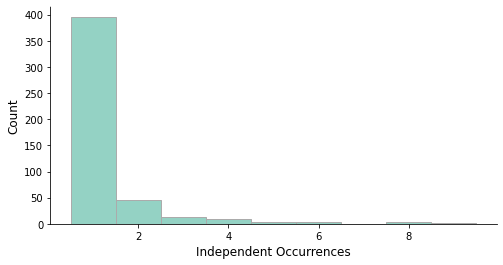

In [5]:
histogram_of_occurrences()

For every observed mutation, find the logistic growth rate of every clade that mutation occurs in. Make a dataframe with the number of times a mutation occurs, a list of these rates, and the average growth rate of clades with this mutation

In [6]:
df = convergent_evo_dataframe(tree, all_mutations_unique, independent_occurrences_all_mutations)

Plot number of occurrences versus average logisitic growth rate for each mutation. Zoom into the mutations that occur 4 or more times and label them

This function creates Figure 4A and Figure 4 Supplement 2.

In [13]:
def fig4a_occurrences_vs_growth(df, fig_to_plot, min_occurrences = 4, plot=True, filename=False):
    """
    Function to plot each mutation as a point in a scatterplot, with x-axis being the 
    number of times this mutation occurred across the phylogeny and the y-axis being 
    the average logistic growth rate of all clades where mutation occurs
    """
    
    # get rid of any entries that have NaN values for growth
    df = df.dropna()
    
    # take a subset of the data, only including mutations that appear `min_occurrences` of more times
    df_zoom = df.loc[df['independent_occurrences']>=min_occurrences].reset_index()
    
    # add a column saying whether or not the mutation occurs in S1
    df_zoom['mutation_location'] = df_zoom.apply(lambda row: 'S1' if row['mutation']== 'S:69/70del' 
                                                 else 'S1' if row['mutation'][0]=='S' 
                                                 and int(row['mutation'].split(':')[1][1:-1])<=685
                                                 and int(row['mutation'].split(':')[1][1:-1])>=13
                                                 else 'other', axis=1)

    
    # allow plotting to be toggled off to just return a list of top_scoring_muts
    # this is used to make Figure 4 Supplement 1
    if plot == False:

        top_scoring_muts = []
        for i in range(df_zoom.shape[0]):
            top_scoring_muts.append({'mutation':df_zoom.mutation[i], 
                                     'rate': df_zoom.avg_growth[i], 
                                     'num_occurrences': df_zoom.independent_occurrences[i], 
                                     'mutation_location': df_zoom.mutation_location[i]})
        
        top_scoring_muts_df = pd.DataFrame(top_scoring_muts)
        return top_scoring_muts_df
    
    
    # this makes Figure 4A and Supplement 2
    elif plot == True:
        
        # make dictionary with specifications specific to each different plot
        # this specifies title and adjustments to make labels more legible
        fig_specifications = {'4a':{'date_text': 'May 15, 2021', 'label':'A', 'adjustments': 
                                    {'S:501Y':{'x':0.075, 'y':0.4}, 
                                     'S:681R':{'x':0.075, 'y':-0.5}, 'S:69/70del':{'x':0.075, 'y':0.1},
                                     'N:199L':{'x':0.075, 'y':0.4}}}, 
                              'supp_before':{'date_text': 'April 15, 2021', 'label':'A', 
                                             'adjustments': {'S:501Y':{'x':0.075, 'y':0.2}, 
                                                             'ORF9b:10S':{'x':0.075, 'y':-0.7},
                                                             'ORF1a:3675-3677del':{'x':-0.6, 'y':+0.45}}}, 
                              'supp_after':{'date_text': 'June 15, 2021', 'label':'C', 
                                            'adjustments': {'S:501Y':{'x':0.075, 'y':0.1}, 
                                                            'N:205I':{'x':0.075, 'y':0.2},
                                                            'N:199L':{'x':0.075, 'y':-0.4}}}}

        # two subplots: one showing all mutations, 
        # and one zoomed in to the mutations with highest values on both axes
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,6), gridspec_kw={'width_ratios': [1.5, 5]})
        sns.set_style('white')

        cmap1 = {'S1':"#4770eb",'other':"#ff5e31"}
        
        # plot all mutations on the first axis
        sns.scatterplot(x='independent_occurrences', y='avg_growth', 
                        data=df, ax=ax1, alpha=0.3,
                        color='#888888', legend = False)

        # find the "avg_growth" range of all mutations with at least `min_occurrences`
        max_growth = df[df['independent_occurrences']>=min_occurrences]['avg_growth'].max()
        min_growth = df[df['independent_occurrences']>=min_occurrences]['avg_growth'].min()


        # find max number of occurrences
        max_occurrences = df['independent_occurrences'].max()

        # plot mutations that occur 4 or more times on second axis
        sns.scatterplot(x='independent_occurrences', y='avg_growth', 
                        data=df_zoom, ax=ax2, s=100,
                        hue = 'mutation_location', hue_order=['S1', 'other'],
                        palette=cmap1, zorder=1)
        
        ax1.set_xlim(0, (max_occurrences + 1.0))
        ax1.set_xlabel('Independent occurrences of mutation', fontsize = 12)
        ax1.set_ylabel('Mean Logisitic Growth Rate', fontsize = 12)

        # truncate the plot space to only include relevant space around the mutations that occur 4 or more times
        ax2.set_ylim((min_growth - 1), (max_growth + 1))
        ax2.set_xlim((min_occurrences - 0.5), (max_occurrences + 0.75))
        ax2.set_xlabel('', fontsize = 12)
        ax2.set_ylabel('', fontsize = 12)
        ax2.set_title(fig_specifications[fig_to_plot]['date_text'], fontsize=14)
        
        # add a box to the first plot showing the area included in the inset (second axis)
        ax1.add_patch(
            patches.Rectangle(
                xy=((min_occurrences - 0.5), (min_growth - 1)),  # point of origin.
                width=(max_occurrences - min_occurrences + 1),
                height= (max_growth - min_growth + 2),
                linewidth=1,
                color='#ffcec1',
                fill=False))
        
        # add horizontal line showing the mean growth rate of all clades on tree
        mean_growth_rate = mean_rate_on_tree(tree)
        ax2.axhline(mean_growth_rate, color='#ffcec1', lw=2, linestyle='--')

        # adjust appearance of axes
        ax1.spines['top'].set_color('white')
        ax1.spines['right'].set_color('white')
        
        ax2.spines['bottom'].set_color('#ffbeac')
        ax2.spines['top'].set_color('#ffbeac')
        ax2.spines['left'].set_color('#ffbeac')
        ax2.spines['right'].set_color('#ffbeac')
        
        plt.xticks(fontsize= 12)
        plt.yticks(fontsize= 12)

        # manually move some of the labels to make more legible
        for i in range(df_zoom.shape[0]):
            label_gene = df_zoom.mutation[i].split(':')[0]
            label_mut = df_zoom.mutation[i].split(':')[1][1:]

            label = f'{label_gene}:{label_mut}'
            if df_zoom.mutation[i] == 'ORF1a:3675-3677del':
                label = 'ORF1a:3675-3677del'
            elif df_zoom.mutation[i] == 'S:69/70del':
                label = 'S:69/70del'

            
            #manually specify adjustments to make labels legible
            adjustments = fig_specifications[fig_to_plot]['adjustments']
                
            if df_zoom.mutation[i] not in ['ORF1a:3676','ORF1a:3677']: 
                if label in adjustments.keys():
                    adjust_x = adjustments[label]['x']
                    adjust_y = adjustments[label]['y']
                else:
                    adjust_x = 0.075
                    adjust_y = -0.2
                ax2.text(x=df_zoom.independent_occurrences[i]+adjust_x,
                         y=df_zoom.avg_growth[i]+adjust_y,
                         s=label, 
                         ha='left',
                         fontdict=dict(color='black',size=10, rotation=0))

                
    handles, labels = ax2.get_legend_handles_labels()
    lgd = ax2.legend(handles, labels, title='Mutation Location')
    
    plt.figtext(0.04, 0.9, fig_specifications[fig_to_plot]['label'], fontsize=24, fontweight='bold')
    
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

    

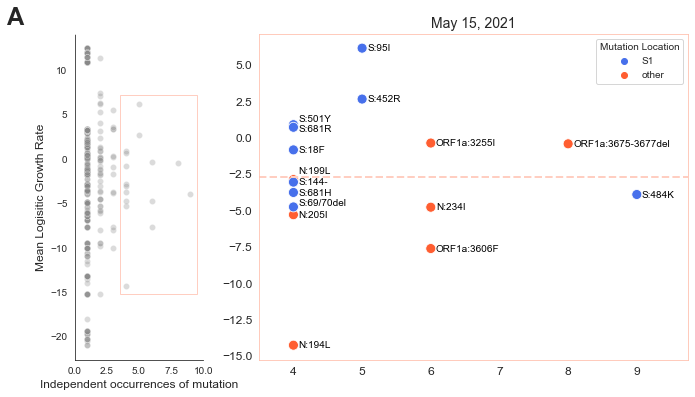

In [14]:
fig4a_occurrences_vs_growth(df, fig_to_plot='4a', filename='plots/fig4a_20210515.png')

Make the same plot for a tree with maximum isolate date one month earlier

This is Figure 4 Supplement 2A

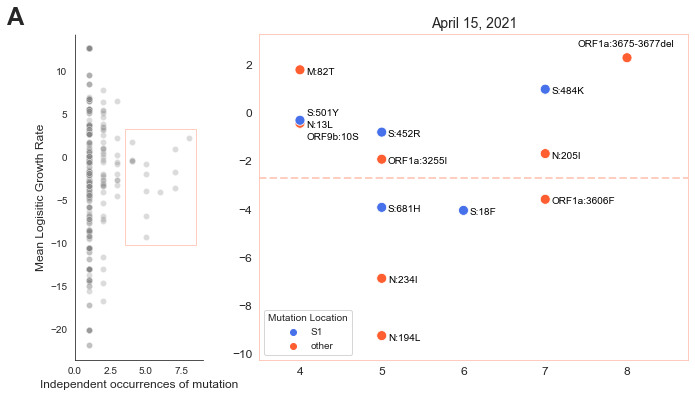

In [16]:
# get tree from April 15
tree_before_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-04-15.json'
tree_before_json = requests.get(tree_before_url).json()
tree_before = json_to_tree(tree_before_json)

all_mutations_unique_before, independent_occurrences_all_mutations_before = count_independent_occurrences(tree_before)

df_before = convergent_evo_dataframe(tree_before, all_mutations_unique_before, 
                                     independent_occurrences_all_mutations_before)

fig4a_occurrences_vs_growth(df_before, fig_to_plot='supp_before', filename='plots/fig4a_supp_20210415.png')

And for one month after the primary analysis

This is Figure 4 Supplement 2C

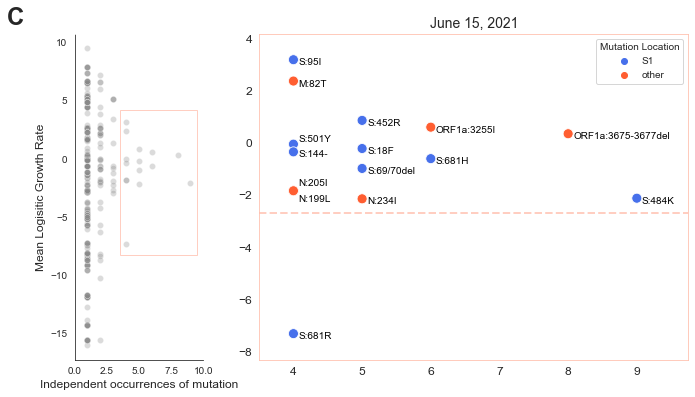

In [17]:
# get tree from June 15
tree_after_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-06-15.json'
tree_after_json = requests.get(tree_after_url).json()
tree_after = json_to_tree(tree_after_json)

all_mutations_unique_after, independent_occurrences_all_mutations_after = count_independent_occurrences(tree_after)

df_after = convergent_evo_dataframe(tree_after, all_mutations_unique_after, 
                                     independent_occurrences_all_mutations_after)

fig4a_occurrences_vs_growth(df_after, fig_to_plot='supp_after', filename='plots/fig4a_supp_20210615.png')

Now randomize the mutations on the tree to make a null expectation for average growth rate given a certain number of independent occurrences. To do this, take every mutation that occurred on an internal branch and randomly select a branch for it to occur on. Ensure that the randomization makes phylogenetic sense (a given mutation does not occur twice on any path through the tree) 

For each randomization, the number of occurrences of a mutation and average growth rate are saved in a .json file in the "randomized_mut_rate_stats/" directory

In [18]:
def expected_growth_on_randomized_tree(tree, num_iterations, mutations_unique, 
                                       independent_occurrences, save_filename):
    """
    Function to randomize the mutations on the tree 
    and return a dataframe with the number of times each mutation 
    occurs and the average growth rate
    """
    
    # make list of all nonsynonymous mutations observed on internal branches of tree 
    # to be placed on tree at random
    bag_of_mutations = [mut for mut,x in independent_occurrences.items() for y in range(x)]
    
    # get the branch lengths and names of all internal branchs
    branch_names_all, branch_lengths_all = get_branch_lengths(tree, num_tips=15)
    
    # initialize a dictionary to store info from all iterations
    mut_growth_stats_dict = {'mutation_growth_rate_stats':[]}
    
    # run the tree randomization the specified number of times
    for i in range(int(num_iterations)):
        random_tree = 'bad_randomization'
        
        # run randomization until it works
        while random_tree == 'bad_randomization':
            # randomize positions of mutations on tree
            random_tree = randomize_specific_mutations_multinomial(tree, bag_of_mutations, 
                                                                   branch_lengths_all, branch_names_all)
            

        # all_mutations_unique will be the same for randomized and empirical data
        growth_dict_random = rates_randomized_mut(mutations_unique, random_tree)
        growth_by_mut_mean_random = calc_mean_rate(growth_dict_random)


        for mut, rate in growth_by_mut_mean_random.items():
            num_occurrences = independent_occurrences[mut]
            
            mut_growth_stats_dict['mutation_growth_rate_stats'].append({'data': 'randomized', 'iteration':i,
                                                                        'num_occurrences':num_occurrences, 
                                                                        'rate': rate})


    with open(save_filename, 'w') as outfile:
        json.dump(mut_growth_stats_dict, outfile)

In [ ]:
expected_growth_on_randomized_tree(tree, 100, all_mutations_unique, 
                                   independent_occurrences_all_mutations, 
                                   'randomized_mut_rate_stats/randomized_mut_rate_stats_100its.json')

Run the randomization using the tree one month before

In [ ]:
expected_growth_on_randomized_tree(tree_before, 100, all_mutations_unique_before, 
                                   independent_occurrences_all_mutations_before, 
                                   'randomized_mut_rate_stats/randomized_mut_rate_stats_100its_before.json')

And one month after

In [19]:
expected_growth_on_randomized_tree(tree_after, 100, all_mutations_unique_after, 
                                   independent_occurrences_all_mutations_after, 
                                   'randomized_mut_rate_stats/randomized_mut_rate_stats_100its_after.json')

Use the randomized trees to create an expectation for the relationship between number of occurrences versus mean growth rate for each convergently-evolved mutation. Plot the distribution of expected values and label the empirical values that exceed the 90th percentile of expectations.

This creates Figure 4B and Figure 4 Supplement 2 panels B and D.

In [28]:
def fig4b(convergent_evo_df, data_files, filename=False):

    # initialize dataframe to store information from all .json files where data is stored
    randomized_df = pd.DataFrame(columns = ['data', 'iteration', 'num_occurrences', 'rate'])
    
    # read in growth rates/num_occurrences from all randomizations
    for data_file in data_files:
        with open(data_file) as json_file:
            data = json.load(json_file)
            temp_df = pd.DataFrame(data['mutation_growth_rate_stats'])
            randomized_df = pd.concat([randomized_df, temp_df])

    
    all_num_occurrences = list(set(randomized_df.num_occurrences))
    
    fig, ax = plt.subplots(figsize=(10,4))

    sns.boxplot(x='num_occurrences', y='rate', data=randomized_df, 
                  dodge=True, zorder=1, order=[i for i in range(all_num_occurrences[0], all_num_occurrences[-1]+1)],
                  color='#ededed', ax=ax)
    
    empirical_df = fig4a_occurrences_vs_growth(convergent_evo_df, '4a', plot=False)
    
    # have to adjust the num_occurrences to zero-based
    empirical_df['num_occurrences'] = empirical_df['num_occurrences']-1
    
    # for each empirical mutation, find percentile of expected data
    percentiles = []
    for k,v in empirical_df.iterrows():
        percentile = stats.percentileofscore(list(
            randomized_df[randomized_df['num_occurrences']==v['num_occurrences']]['rate']), 
                                    v['rate'])
        if percentile >= 90:
            greater_than_90 = True
        else:
            greater_than_90 = False
        percentiles.append(greater_than_90)
    empirical_df['percentile'] = percentiles
    

    
    #size of point depend on percentile, color depends on location in S1 or not 
    cmap1 = {'S1':"#4770eb",'other':"#ff5e31"}
    sns.scatterplot(x='num_occurrences', y='rate', data=empirical_df, 
                    hue='mutation_location', hue_order=['S1', 'other'], palette=cmap1, 
                    size='percentile', sizes={True:300, False:50}, legend=False)
    for i in range(empirical_df.shape[0]):
        if empirical_df.percentile[i] == True:
            label_gene = empirical_df.mutation[i].split(':')[0]
            label_mut = empirical_df.mutation[i].split(':')[1][1:]

            label = f'{label_gene}:{label_mut}'
            if empirical_df.mutation[i] == 'ORF1a:3675-3677del':
                label = 'ORF1a:3675-3677del'
            elif empirical_df.mutation[i] == 'S:69/70del':
                label = 'S:69/70del'
                
                
            if empirical_df.mutation[i] == 'ORF1a:3675-3677del':
                ax.text(x=empirical_df.num_occurrences[i]+0.15,
                         y=empirical_df.rate[i]+10.0,
                         s=label, 
                         ha='left', va='center',
                         fontdict=dict(color=cmap1[empirical_df.mutation_location[i]],size=14, rotation=40))
            elif empirical_df.mutation[i] == 'S:T95I':
                ax.text(x=empirical_df.num_occurrences[i]+0.15,
                         y=empirical_df.rate[i]+4.0,
                         s=label, 
                         ha='left', va='center',
                         fontdict=dict(color=cmap1[empirical_df.mutation_location[i]],size=14, rotation=40))
            else:
                ax.text(x=empirical_df.num_occurrences[i]+0.15,
                         y=empirical_df.rate[i]+5.0,
                         s=label, 
                         ha='left', va='center',
                         fontdict=dict(color=cmap1[empirical_df.mutation_location[i]],size=14, rotation=40))


    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')

    ax.set_ylabel('Mean Logistic Growth Rate', fontsize = 14)
    ax.set_xlabel('Number of occurrences', fontsize = 14)

    plt.yticks(fontsize= 16)
    plt.xticks(fontsize= 16)
    
    plt.figtext(0.0, 0.9, 'B', fontsize=24, fontweight='bold')
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

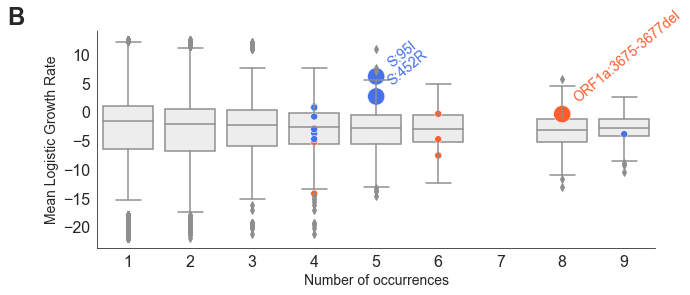

In [29]:
fig4b(df, ['randomized_mut_rate_stats/randomized_mut_rate_stats_100its.json'],filename='plots/fig4b_20210515.png')

In [ ]:
fig4b(df_before, ['randomized_mut_rate_stats/randomized_mut_rate_stats_100its_before.json'],
      filename='plots/fig4b_supp_20210415.png')

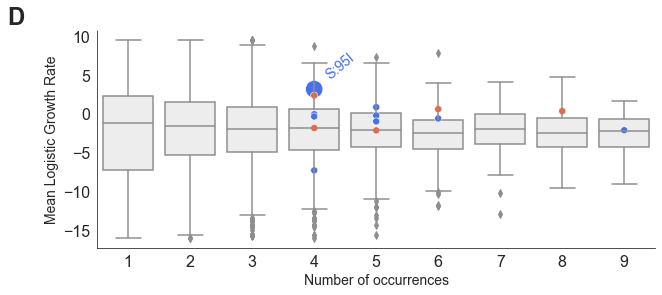

In [21]:
fig4b(df_after, ['randomized_mut_rate_stats/randomized_mut_rate_stats_100its_after.json'],
      filename='plots/fig4b_supp_20210615.png')

Now, consider each occurrence of the convergently-evolved mutations and determine what (if any) emerging lineages descend from this mutation

In [ ]:
def find_lineages_descending_from_muts(tree):
    
    # get a list of convergently-evolved mutations
    top_scoring_muts_df = fig4a_occurrences_vs_growth(df, '4a', plot=False)
    top_scoring_muts = list(top_scoring_muts_df['mutation'])

    # initialize dictionary to store emerging lineages descending 
    # from a convergently-evoled mutation 
    # key is mutation, value is a dictionary with key as node 
    # names where mutation occurred and value as list of emerging 
    # lineages descending from this node
    emerging_lineages_descending_from_mut = {x:{} for x in top_scoring_muts}

    for node in tree.find_clades(terminal=True):

        emerging_lineage = node.node_attrs["emerging_lineage"]["value"]

        parents = get_parent(tree, node)
        
        # look only at branches with 15 or more descending tips
        for parent in parents:
            if len(parent.get_terminals()) >=15:

                if hasattr(parent, 'branch_attrs'):
                    
                    # see if the convergently-evolved mutations occur in the parents of this node
                    for mut in top_scoring_muts:
                        gene = mut.split(':')[0]
                        mutation = mut.split(':')[1]
                        if mut=='ORF1a:3675/3676/3677del':
                            mutation = 'S3675-'
                        elif mut == 'S:69/70del':
                            mutation = 'H69-'

                        
                        if gene in parent.branch_attrs["mutations"]:
                            if mutation in parent.branch_attrs["mutations"][gene]:
                                # parent name is node where mutation occurred
                                if parent.name in emerging_lineages_descending_from_mut[mut].keys():
                                    # if this emerging lineage is not already listed as descending from this node, add it
                                    if emerging_lineage not in emerging_lineages_descending_from_mut[mut][parent.name]:
                                        emerging_lineages_descending_from_mut[mut][parent.name].append(emerging_lineage)
                                else:
                                    emerging_lineages_descending_from_mut[mut][parent.name] = [emerging_lineage]
                                    
    return emerging_lineages_descending_from_mut
                        

In [ ]:
def tidy_descending_lineage_data(tree, save_filename):
    
    emerging_lineages_descending_from_mut = find_lineages_descending_from_muts(tree)
    
    to_plot = []

    for k,v in emerging_lineages_descending_from_mut.items():
        # reformat mutation name
        if k == 'ORF1a:3575/3676/3677del':
            mutation = 'ORF1a:3575-3677del'
        else:
            mutation = k.split(':')[0]+':'+k.split(':')[1][1:]
        num_occurrences = len(v)

        for v_k, v_v in v.items():
            if len(v_v) == 1:
                descending_lineage = v_v[0]
            if len(v_v) == 2:
                if 'unassigned' in v_v:
                    v_v.remove('unassigned')
                    descending_lineage = v_v[0]
                else:
                    descending_lineage = 'multiple'
            if len(v_v) > 2:
                descending_lineage = 'multiple'
            
            to_plot.append({'mutation': mutation, 'num_occurrences': num_occurrences, 
                            'desending_lineage': convert_linege_names(descending_lineage)})

    to_plot_df = pd.DataFrame(to_plot)
    
    emerging_lineages_dict = {'lineages_descending_from_mut':to_plot}
    
    with open(save_filename, 'w') as outfile:
        json.dump(emerging_lineages_dict, outfile)
    
    return to_plot_df

In [ ]:
def fig4_supp1_descending_lineages(tree, save_filename, filename=False):
    """
    For each independent occurrence of a convergently-evolved mutation, 
    plot what emerging lineages descend from it 
    """
    
    if os.path.exists(save_filename):
        with open(save_filename) as json_file:
            data = json.load(json_file)
            to_plot_df = pd.DataFrame(data['lineages_descending_from_mut'])
    
    else:
        to_plot_df = tidy_descending_lineage_data(tree, save_filename)

    fig, ax = plt.subplots(figsize=(6,8))
    ax.invert_yaxis()

    # reorder dataframe to rank consistent mutations highest
    possible_muts = to_plot_df['mutation'].value_counts().index.tolist()
    
    possible_lineages = sorted(list(to_plot_df['desending_lineage'].unique()))
    possible_lineages.remove('basal')
    possible_lineages.remove('multiple')

    # get the nextstrain colors for emerging lineages
    colors_to_use = get_color_palette(len(possible_lineages))


    cmap = dict(zip(possible_lineages, colors_to_use))
    
    possible_lineages+=['multiple', 'basal']
    cmap['basal'] = "#ABABAB"
    cmap['multiple'] = "#CBC3E3"

    x_ticks = list(range(len(possible_muts)))
    last_bars = np.array([0 for x in possible_muts])
    for y in possible_lineages:
        lineage_bars = []
        for x in possible_muts:
            lineage_bars.append(len(to_plot_df[(to_plot_df['mutation']==x) & (to_plot_df['desending_lineage']==y)]))

        plt.barh(x_ticks, lineage_bars, left=last_bars, height=0.5, color = cmap[y], edgecolor='white', label = y)
        last_bars = last_bars + np.array(lineage_bars)

    plt.yticks(x_ticks, possible_muts, rotation=40, ha='right')
    ax.set_xlabel('Independent Occurrences', fontsize = 12)
    ax.set_xlim(0, (max(last_bars))+0.5)


    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.9, 0.7))

    sns.despine(left=False, bottom=False)
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    

In [ ]:
fig4_supp1_descending_lineages(tree, save_filename = 'emerging_lineages/emerging_lineages_after_mutation.json', 
                               filename='plots/fig4_supp1_20210515_new.png')